# Tutorial for maneuvering simulation of esso osaka (3 meter model ship)

### Import library

In [1]:
import warnings
import numpy as np
from IPython.display import Image

import pyshipsim
from utils import font_setting

warnings.simplefilter('ignore')
font_setting()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
ImportError: Import of esso_osaka_3m's f2py mpdule failed.
ImportError: Import of esso_osaka_3m's f2py mpdule failed.
ImportError: Import of takaoki_3m's f2py mpdule failed.


### Instantiate ship module

In [2]:
# You can select `EssoOsaka3mMMG` or `EssoOsaka3mMMGWithActuaorResponse`.
ship = pyshipsim.EssoOsaka3mMMG()
# `EssoOsaka3mMMGWithActuaorResponse` include actuator response model.
ship = pyshipsim.EssoOsaka3mMMGWithActuaorResponse() 
# You can choose to use the ODE solver and the fortran backend.
ship = pyshipsim.EssoOsaka3mMMG(solve_method="euler", f2py=False)
print(f"Implemented ODE Solver are {ship.implemented_solve_method}")

Implemented ODE Solver are ['euler', 'rk4']


### Instantiate world and simulator module

In [3]:
world = pyshipsim.OpenSea()

# Note : The generator module for wind variables is included in the world module. 
#        Before instantiating the world module, you can choose the type of wind module.
wind = pyshipsim.WindProcess(mode="random")
world = pyshipsim.OpenSea(wind=wind)

# How to simulate ship maneuvering motions

Overview
1. Define simulator : Parameters and componets of simulator are determined.
1. Reset simulator : Initial condition of state variables is determined.
1. Simulation loop : The simulation is progressed step-by-step with giving instantaneous actions.
1. Save log : Simulation results are saved as csv-files or pdf-images.

---

### Step 1 : Define simulator

Args:
- ship (SurfaceShip): instance of ship module.
- world (World): instance of world module.
- dt_act (float, optional): Timestep of action. Defaults to 1.0.
- dt_sim (float, optional): Timestep of numerical integration. Defaults to 0.1.
- check_collide (bool, optional): Handle whether to use the collision detection module. Defaults to False.

### Step 2 : Reset simulator

Class method : `.reset()`

Args:
- state (numpy.typing.ArrayLike): Initial condition of state variables
- seed (int | np.random.Generator, optional): random seed. Defaults to None.

Returns:
- ObsType (numpy.typing.NDArray): observation variables

### Step 3 : Simulation loop

Class method : `.step()`

Args:
- action (numpy.typing.ArrayLike): Action variables

Returns:
- numpy.typing.NDArray: Observation variable for the next step
- bool: Handle to determine the end of simulation
- dict: Additional infomation

### Step 4 : Save log

Class method : `.log2csv()` and `.log2img()`

Args:
- fname (str): file name

In [4]:
sim = pyshipsim.ManeuveringSimulation(
    ship=ship,
    world=world,
    dt_act=1.0,
    dt_sim=0.1,
    check_collide=False,
)

# you can access the name of state and action variavles
print(f'State variables: {sim.STATE_NAME}')
print(f'Action variables: {sim.ACTION_NAME}')

State variables: ['x_position_mid [m]', 'u_velo [m/s]', 'y_position_mid [m]', 'vm_velo [m/s]', 'psi [rad]', 'r_angvelo [rad/s]', 'true_wind_speed [m/s]', 'true_wind_direction [rad]']
Action variables: ['delta_rudder [rad]', 'n_prop [rps]']


In [5]:
# Define initial state variables
x_position_mid = 0.0
u_velo = 0.1
y_position_mid = 0.0
vm_velo = 0.0
psi = 0.0
r_angvelo = 0.0

true_wind_speed = 0.2
true_wind_direction = np.pi

state = np.array([
    x_position_mid, u_velo, y_position_mid, vm_velo, psi, r_angvelo,
    true_wind_speed, true_wind_direction
])

# reset simulator and get the observation variables
observation = sim.reset(state, seed=100)

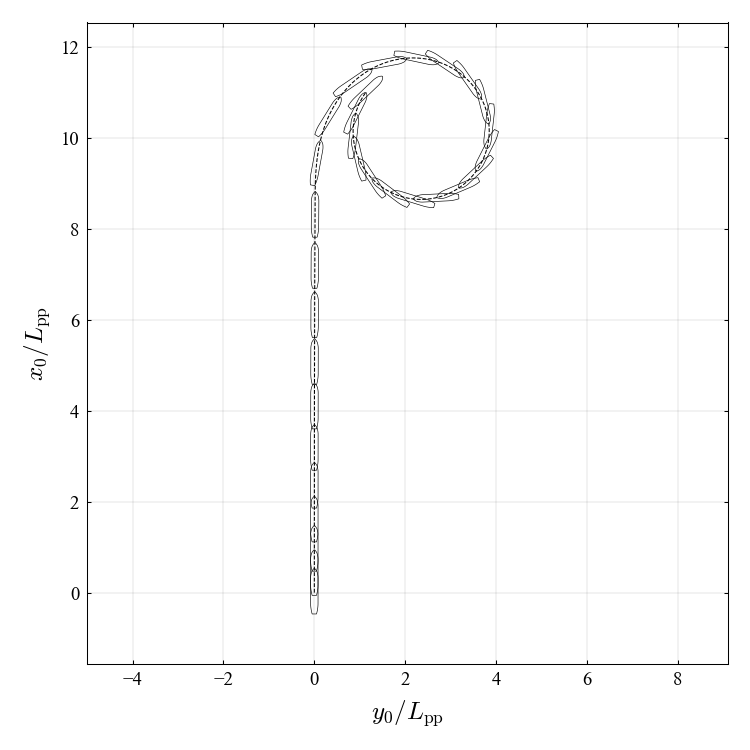

In [6]:
# simulation roop
delta_rudder_cmd = 30 * np.pi/180 # (rad)
n_prop_cmd = 10.0 # (rps)
while sim.get_time() < 300:
    action = np.array([delta_rudder_cmd,  n_prop_cmd])
    if sim.get_time() < 100:    
        action = np.array([0.0, n_prop_cmd])
    observation, terminated, info = sim.step(action)
    if terminated:
        break

# save
sim.log2csv(dir='./log/tutorial_esso/', fname='turning')
sim.log2img(dir='./log/tutorial_esso/', fname='turning', ext_type='png')

Image("./log/tutorial_esso/turning_trajectory.png")

## Other examples

### Simulation of zigzag test with actuator response model

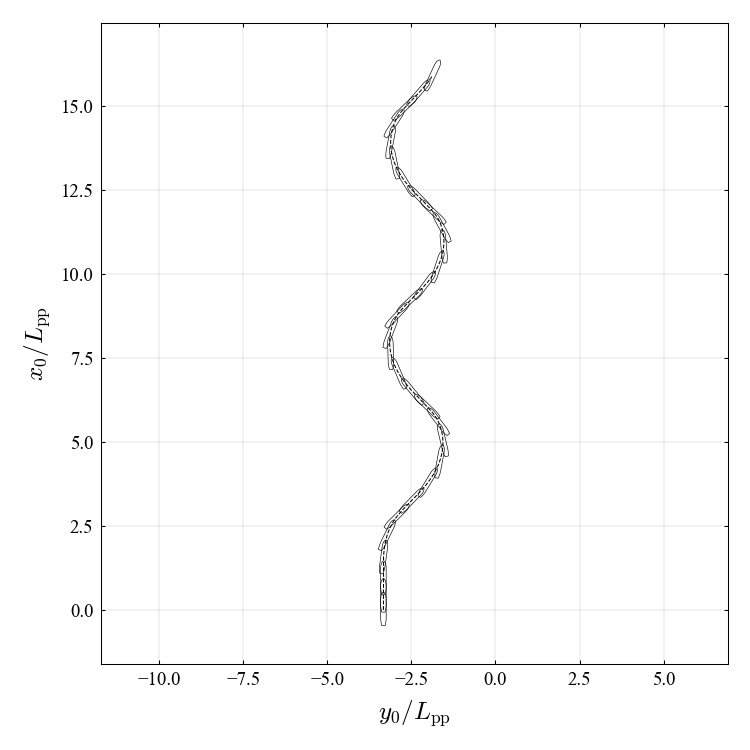

In [7]:
ship = pyshipsim.EssoOsaka3mMMGWithActuaorResponse()
world = pyshipsim.OpenSea()
sim = pyshipsim.ManeuveringSimulation(
    ship=ship,
    world=world,
    dt_act=1.0,
    dt_sim=0.1,
    check_collide=False,
)

# Define initial state variables
x_position_mid = 0.0
u_velo = 0.1
y_position_mid = -10.0
vm_velo = 0.0
psi = 0.0
r_angvelo = 0.0

delta_rudder = 0.0
n_prop = 1e-8

true_wind_speed = 0.2
true_wind_direction = np.pi

state = np.array([
    x_position_mid, u_velo, y_position_mid, vm_velo, psi, r_angvelo,
    delta_rudder, n_prop,
    true_wind_speed, true_wind_direction
])

# reset simulator and get the observation variables
observation = sim.reset(state, seed=100)

# control law
def z_test(t, psi, delta_rudder, delta_rudder_cmd):
    DELTA = 35*np.pi/180
    if t < 20.0:
        delta_rudder_cmd = 0.0
    else:
        if 0.0 <= delta_rudder:
            if DELTA <= psi:
                delta_rudder_cmd = -DELTA
            else:
                delta_rudder_cmd = DELTA
        else:
            if psi <= -DELTA:
                delta_rudder_cmd = DELTA
            else:
                delta_rudder_cmd = -DELTA
    return delta_rudder_cmd

# simulation roop
delta_rudder_cmd = 0.0
n_prop_cmd = 10.0
while sim.get_time() < 300:
    psi = observation[4]
    delta_rudder = observation[6]
    delta_rudder_cmd = z_test(sim.get_time(), psi, delta_rudder, delta_rudder_cmd)
    action = np.array([delta_rudder_cmd, n_prop_cmd])
    observation, terminated, info = sim.step(action)
    if terminated:
        break

# save
sim.log2csv(dir='./log/tutorial_esso/', fname='zigzag')
sim.log2img(dir='./log/tutorial_esso/', fname='zigzag', ext_type='png')

Image("./log/tutorial_esso/zigzag_trajectory.png")

### Simulation of ship maneuvering motions with collision detection

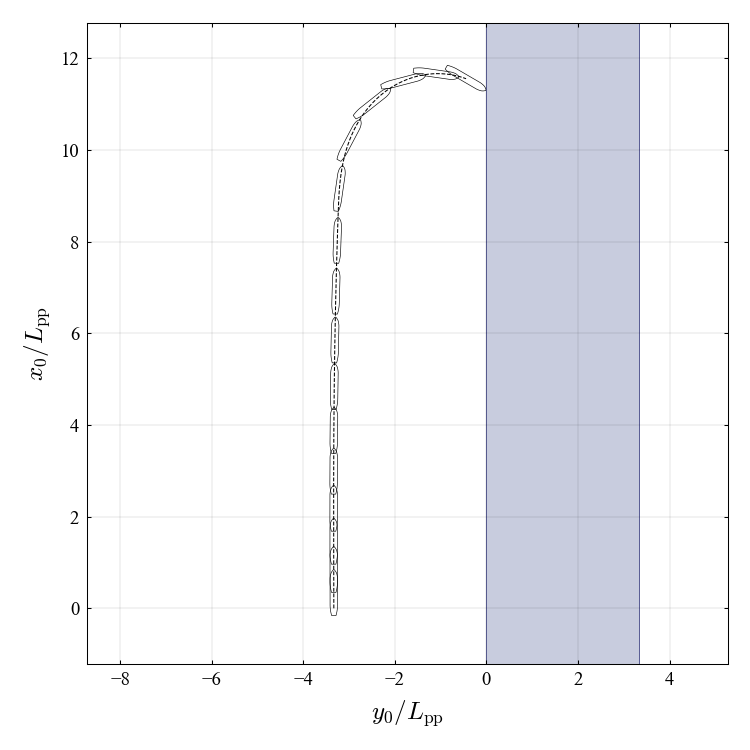

In [8]:
ship = pyshipsim.EssoOsaka3mMMGWithActuaorResponse()
world = pyshipsim.StraightBerth()
sim = pyshipsim.ManeuveringSimulation(
    ship=ship,
    world=world,
    dt_act=1.0,
    dt_sim=0.1,
    check_collide=True,
)

# Define initial state variables
x_position_mid = 0.0
u_velo = 0.1
y_position_mid = -10.0
vm_velo = 0.0
psi = 0.0
r_angvelo = 0.0

delta_rudder = 0.0
n_prop = 1e-8

true_wind_speed = 0.2
true_wind_direction = 0.5*np.pi

state = np.array([
    x_position_mid, u_velo, y_position_mid, vm_velo, psi, r_angvelo,
    delta_rudder, n_prop,
    true_wind_speed, true_wind_direction
])

# reset simulator and get the observation variables
observation = sim.reset(state, seed=100)

# simulation roop
delta_rudder_cmd = 30 * np.pi/180 # (rad)
n_prop_cmd = 10.0 # (rps)
while sim.get_time() < 300:
    action = np.array([delta_rudder_cmd,  n_prop_cmd])
    if sim.get_time() < 100:    
        action = np.array([0.0, n_prop_cmd])
    observation, terminated, info = sim.step(action)
    if terminated:
        break

# save
sim.log2csv(dir='./log/tutorial_esso/', fname='collision')
sim.log2img(dir='./log/tutorial_esso/', fname='collision', ext_type='png')

Image("./log/tutorial_esso/collision_trajectory.png")